In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import SimpleITK as sitk
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from NoduleDS import NoduleDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [2]:
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
IMAGE_SIZE = 224
NUM_WORKERS = 4
WEIGHT_DECAY = 0.01

# Paths - using pre-split data to avoid leakage
split_base_path = "./dataset_nodule21/cxr_images/proccessed_data/split_data"

train_images_path = os.path.join(split_base_path, "train", "images")
val_images_path = os.path.join(split_base_path, "val", "images")
test_images_path = os.path.join(split_base_path, "test", "images")

train_csv_path = os.path.join(split_base_path, "train", "metadata_train.csv")
val_csv_path = os.path.join(split_base_path, "val", "metadata_val.csv")
test_csv_path = os.path.join(split_base_path, "test", "metadata_test.csv")

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=3),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
# %% Load Pre-Split Data

# Also load original data for before/after comparison 
original_csv_path = "./nodule_dataset21/cxr_images/proccessed_data/metadata.csv"

print("Loading metadata...")
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Try to load original data
try:
    original_df = pd.read_csv(original_csv_path)
    has_original = True
    print(f"Original dataset: {len(original_df)} samples")
except:
    has_original = False
    print("Original metadata not found, skipping before/after comparison")

print(f"Train: {len(train_df)} samples")
print(f"Val: {len(val_df)} samples")
print(f"Test: {len(test_df)} samples")

# Combine all splits for total distribution
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(f"Total (combined): {len(combined_df)} samples")

# %% Beautiful color palette
color_negative = '#667eea'  # Soft purple
color_positive = '#f093fb'  # Soft pink
colors = [color_negative, color_positive]

# %% Figure 1: Before vs After Upsampling (if original data exists)
if has_original:
    fig1, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig1.patch.set_facecolor('white')
    
    # Original distribution - Bar
    original_counts = original_df['label'].value_counts().sort_index()
    axes[0, 0].bar(['No Nodule', 'Nodule'], original_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[0, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[0, 0].set_title('Original Dataset (Before Split & Upsample)', fontsize=15, fontweight='bold', pad=15)
    axes[0, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[0, 0].set_facecolor('#ffffff')
    for i, v in enumerate(original_counts.values):
        axes[0, 0].text(i, v + 50, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # Original distribution - Pie
    wedges, texts, autotexts = axes[0, 1].pie(original_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[0, 1].set_title('Original Distribution (%)', fontsize=15, fontweight='bold', pad=15)
    
    # After split & upsample - Bar
    combined_counts = combined_df['label'].value_counts().sort_index()
    axes[1, 0].bar(['No Nodule', 'Nodule'], combined_counts.values, 
                   color=colors, alpha=0.85, edgecolor='white', linewidth=2)
    axes[1, 0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
    axes[1, 0].set_title('After Split & Upsample (All Splits Combined)', fontsize=15, fontweight='bold', pad=15)
    axes[1, 0].grid(axis='y', alpha=0.3, linestyle='--')
    axes[1, 0].set_facecolor('#ffffff')
    for i, v in enumerate(combined_counts.values):
        axes[1, 0].text(i, v + 100, str(v), ha='center', va='bottom', 
                        fontsize=12, fontweight='bold', color=colors[i])
    
    # After split & upsample - Pie
    wedges, texts, autotexts = axes[1, 1].pie(combined_counts.values, 
                                               labels=['No Nodule', 'Nodule'], 
                                               autopct='%1.1f%%',
                                               colors=colors, 
                                               startangle=90,
                                               explode=(0.05, 0.05),
                                               shadow=True)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(11)
    for text in texts:
        text.set_fontsize(12)
        text.set_fontweight('bold')
    axes[1, 1].set_title('After Split & Upsample (%)', fontsize=15, fontweight='bold', pad=15)
    
    plt.tight_layout()
    plt.savefig('before_after_split_upsample.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("\n✓ Before/After comparison saved to 'before_after_split_upsample.png'")

Loading metadata...
Original metadata not found, skipping before/after comparison
Train: 5725 samples
Val: 782 samples
Test: 785 samples
Total (combined): 7292 samples


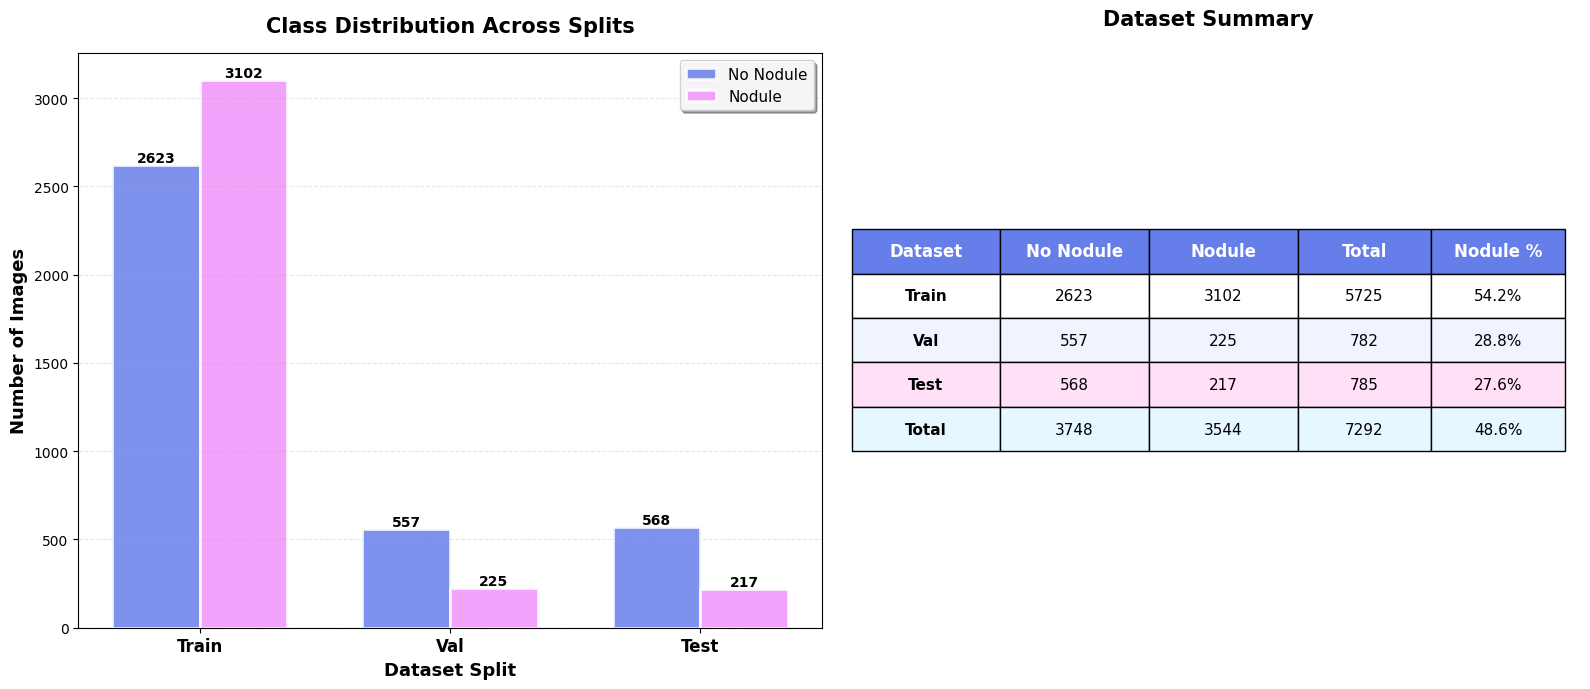

✓ Split distribution saved to 'split_distribution.png'


In [5]:
# %% Figure 2: Train/Val/Test Distribution
fig2, axes = plt.subplots(1, 2, figsize=(16, 7))
fig2.patch.set_facecolor('white')

# Grouped bar chart
splits_data = {
    'Train': train_df['label'].value_counts().sort_index(),
    'Val': val_df['label'].value_counts().sort_index(),
    'Test': test_df['label'].value_counts().sort_index()
}

x = np.arange(len(splits_data))
width = 0.35
bars1 = axes[0].bar(x - width/2, [splits_data[k][0] for k in splits_data.keys()], 
                    width, label='No Nodule', color=color_negative, alpha=0.85, 
                    edgecolor='white', linewidth=2)
bars2 = axes[0].bar(x + width/2, [splits_data[k][1] for k in splits_data.keys()], 
                    width, label='Nodule', color=color_positive, alpha=0.85, 
                    edgecolor='white', linewidth=2)

axes[0].set_xlabel('Dataset Split', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=13, fontweight='bold')
axes[0].set_title('Class Distribution Across Splits', fontsize=15, fontweight='bold', pad=15)
axes[0].set_xticks(x)
axes[0].set_xticklabels(splits_data.keys(), fontsize=12, fontweight='bold')
axes[0].legend(fontsize=11, framealpha=0.9, shadow=True)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_facecolor('#ffffff')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Summary table
summary_data = []
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df), ('Total', combined_df)]:
    no_nodule = (split_df['label'] == 0).sum()
    nodule = (split_df['label'] == 1).sum()
    total = len(split_df)
    nodule_pct = f"{nodule/total*100:.1f}%" if total > 0 else "0%"
    summary_data.append([split_name, no_nodule, nodule, total, nodule_pct])

if has_original:
    # Add original row at the top
    orig_no_nodule = (original_df['label'] == 0).sum()
    orig_nodule = (original_df['label'] == 1).sum()
    orig_total = len(original_df)
    orig_pct = f"{orig_nodule/orig_total*100:.1f}%"
    summary_data.insert(0, ['Original', orig_no_nodule, orig_nodule, orig_total, orig_pct])

axes[1].axis('tight')
axes[1].axis('off')
table = axes[1].table(cellText=summary_data,
                      colLabels=['Dataset', 'No Nodule', 'Nodule', 'Total', 'Nodule %'],
                      cellLoc='center',
                      loc='center',
                      colWidths=[0.2, 0.2, 0.2, 0.18, 0.18])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header with gradient
for i in range(5):
    table[(0, i)].set_facecolor('#667eea')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Alternate row colors
row_colors = ['#ffffff', '#f0f4ff', '#ffe0f7', '#e6f7ff', '#e8f5e9', '#fff3e0']
for i in range(1, len(summary_data) + 1):
    for j in range(5):
        table[(i, j)].set_facecolor(row_colors[(i-1) % len(row_colors)])
        table[(i, j)].set_text_props(weight='normal' if j > 0 else 'bold')

axes[1].set_title('Dataset Summary', fontsize=15, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('split_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Split distribution saved to 'split_distribution.png'")

In [6]:
# %% Print detailed statistics
print("\n" + "="*70)
print("📊 DETAILED STATISTICS")
print("="*70)

if has_original:
    print("\nORIGINAL DATASET (Before Split):")
    print(f"   Total images: {len(original_df)}")
    print(f"   No Nodule (0): {original_counts[0]:,} ({original_counts[0]/len(original_df)*100:.1f}%)")
    print(f"   Nodule (1): {original_counts[1]:,} ({original_counts[1]/len(original_df)*100:.1f}%)")
    print(f"   Imbalance ratio: 1:{original_counts[0]/original_counts[1]:.2f}")

print("\nAFTER SPLIT & UPSAMPLE:")
print(f"   Total images (combined): {len(combined_df)}")
combined_counts = combined_df['label'].value_counts().sort_index()
print(f"   No Nodule (0): {combined_counts[0]:,} ({combined_counts[0]/len(combined_df)*100:.1f}%)")
print(f"   Nodule (1): {combined_counts[1]:,} ({combined_counts[1]/len(combined_df)*100:.1f}%)")
print(f"   Imbalance ratio: 1:{combined_counts[0]/combined_counts[1]:.2f}")

print("\nINDIVIDUAL SPLITS:")
train_counts = train_df['label'].value_counts().sort_index()
print(f"\n   Training Set ({len(train_df)} images):")
print(f"      No Nodule: {train_counts[0]:,} ({train_counts[0]/len(train_df)*100:.1f}%)")
print(f"      Nodule: {train_counts[1]:,} ({train_counts[1]/len(train_df)*100:.1f}%)")

val_counts = val_df['label'].value_counts().sort_index()
print(f"\n   Validation Set ({len(val_df)} images):")
print(f"      No Nodule: {val_counts[0]:,} ({val_counts[0]/len(val_df)*100:.1f}%)")
print(f"      Nodule: {val_counts[1]:,} ({val_counts[1]/len(val_df)*100:.1f}%)")

test_counts = test_df['label'].value_counts().sort_index()
print(f"\n   Test Set ({len(test_df)} images):")
print(f"      No Nodule: {test_counts[0]:,} ({test_counts[0]/len(test_df)*100:.1f}%)")
print(f"      Nodule: {test_counts[1]:,} ({test_counts[1]/len(test_df)*100:.1f}%)")

print("\n" + "="*70)
print("✨ All visualizations saved successfully!")
print("="*70)


📊 DETAILED STATISTICS

AFTER SPLIT & UPSAMPLE:
   Total images (combined): 7292
   No Nodule (0): 3,748 (51.4%)
   Nodule (1): 3,544 (48.6%)
   Imbalance ratio: 1:1.06

INDIVIDUAL SPLITS:

   Training Set (5725 images):
      No Nodule: 2,623 (45.8%)
      Nodule: 3,102 (54.2%)

   Validation Set (782 images):
      No Nodule: 557 (71.2%)
      Nodule: 225 (28.8%)

   Test Set (785 images):
      No Nodule: 568 (72.4%)
      Nodule: 217 (27.6%)

✨ All visualizations saved successfully!


In [7]:
# Create datasets - each pointing to its own split directory
train_dataset = NoduleDataset(train_df, train_images_path, transform=train_transform, return_bbox=False)
val_dataset = NoduleDataset(val_df, val_images_path, transform=val_transform, return_bbox=False)
test_dataset = NoduleDataset(test_df, test_images_path, transform=val_transform, return_bbox=False)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                       num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        num_workers=NUM_WORKERS, pin_memory=True)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class TransformerBlock(nn.Module):
    """Ultra-lightweight Transformer block with spatial downsampling"""
    def __init__(self, dim, num_heads=2, mlp_ratio=1.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        
        # OPTIMIZATION: Downsample spatial dims for attention if too large
        if H * W > 196:  # If feature map > 14x14
            x_down = F.adaptive_avg_pool2d(x, (14, 14))
            B_d, C_d, H_d, W_d = x_down.shape
            x_seq = x_down.flatten(2).transpose(1, 2)
        else:
            x_seq = x.flatten(2).transpose(1, 2)
            H_d, W_d = H, W
        
        # Multi-head self-attention with residual
        x_norm = self.norm1(x_seq)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x_seq = x_seq + attn_out
        
        # MLP with residual
        x_seq = x_seq + self.mlp(self.norm2(x_seq))
        
        # Reshape back
        x_out = x_seq.transpose(1, 2).reshape(B, C, H_d, W_d)
        
        # Upsample back if needed
        if H_d != H or W_d != W:
            x_out = F.interpolate(x_out, size=(H, W), mode='bilinear', align_corners=False)
        
        return x + x_out  # Residual from original

class ResNetWithMultiScaleAttention(nn.Module):
    """ResNet-50 with lightweight transformer blocks at multiple scales"""
    def __init__(self, num_classes=2, pretrained=True, num_heads=2, dropout=0.1):
        super().__init__()
        
        # Load pretrained ResNet-50
        backbone = timm.create_model('resnet50', pretrained=pretrained, num_classes=0)
        
        # Extract ResNet stages
        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.act1,
            backbone.maxpool
        )
        self.stage1 = backbone.layer1  # Output: 256 channels, H/4 x W/4 (56x56 for 224 input)
        self.stage2 = backbone.layer2  # Output: 512 channels, H/8 x W/8 (28x28)
        self.stage3 = backbone.layer3  # Output: 1024 channels, H/16 x W/16 (14x14)
        self.stage4 = backbone.layer4  # Output: 2048 channels, H/32 x W/32 (7x7)
        
        # Add ultra-lightweight transformer blocks after each stage
        # Using minimal heads and MLP ratio to keep it fast
        self.trans1 = TransformerBlock(256, num_heads=2, mlp_ratio=1.0, dropout=dropout)
        self.trans2 = TransformerBlock(512, num_heads=2, mlp_ratio=1.0, dropout=dropout)
        self.trans3 = TransformerBlock(1024, num_heads=num_heads, mlp_ratio=1.0, dropout=dropout)
        self.trans4 = TransformerBlock(2048, num_heads=num_heads, mlp_ratio=1.0, dropout=dropout)
        
        # Global average pooling and classifier
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        # Stem
        x = self.stem(x)
        
        # Stage 1 + Transformer
        x = self.stage1(x)
        x = self.trans1(x)
        
        # Stage 2 + Transformer
        x = self.stage2(x)
        x = self.trans2(x)
        
        # Stage 3 + Transformer
        x = self.stage3(x)
        x = self.trans3(x)
        
        # Stage 4 + Transformer
        x = self.stage4(x)
        x = self.trans4(x)
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = x.flatten(1)
        x = self.classifier(x)
        
        return x

In [9]:
# Initialize model
print("\nInitializing ResNet-50 with Multi-Scale Attention...")
model = ResNetWithMultiScaleAttention(num_classes=2, pretrained=False, num_heads=2, dropout=0.1)

# Load your trained ResNet-50 weights into the backbone
print("Loading pretrained ResNet-50 weights from ./resnet50_binary.pth...")
checkpoint = torch.load('./resnet50_binary.pth')

# Extract backbone weights from checkpoint
pretrained_dict = checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint

# Create a mapping for the backbone weights
model_dict = model.state_dict()
pretrained_dict_filtered = {}

for k, v in pretrained_dict.items():
    # Map old ResNet keys to new model structure
    if k.startswith('conv1'):
        pretrained_dict_filtered['stem.0.' + k] = v
    elif k.startswith('bn1'):
        pretrained_dict_filtered['stem.1.' + k] = v
    elif k.startswith('layer1'):
        pretrained_dict_filtered['stage1.' + k[7:]] = v
    elif k.startswith('layer2'):
        pretrained_dict_filtered['stage2.' + k[7:]] = v
    elif k.startswith('layer3'):
        pretrained_dict_filtered['stage3.' + k[7:]] = v
    elif k.startswith('layer4'):
        pretrained_dict_filtered['stage4.' + k[7:]] = v
    elif k.startswith('fc'):
        pretrained_dict_filtered['classifier.' + k[3:]] = v

# Update model dict with pretrained weights
model_dict.update(pretrained_dict_filtered)
model.load_state_dict(model_dict, strict=False)
print("✓ Loaded pretrained backbone weights")

model = model.to(device)

# FREEZE the entire backbone (only train transformer blocks + classifier)
for name, param in model.named_parameters():
    if 'trans' not in name and 'classifier' not in name:
        param.requires_grad = False

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
total_params = trainable_params + frozen_params

print(f"\nParameter Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"  Frozen parameters: {frozen_params:,} ({100*frozen_params/total_params:.2f}%)")

# Loss and optimizer (only optimize trainable params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

print("\n✓ Model ready for training!")
print("✓ Frozen: ResNet backbone")
print("✓ Training: Transformer blocks + Classifier")


Initializing ResNet-50 with Multi-Scale Attention...
Loading pretrained ResNet-50 weights from ./resnet50_binary.pth...
✓ Loaded pretrained backbone weights

Parameter Summary:
  Total parameters: 56,973,890
  Trainable parameters: 33,465,858 (58.74%)
  Frozen parameters: 23,508,032 (41.26%)

✓ Model ready for training!
✓ Frozen: ResNet backbone
✓ Training: Transformer blocks + Classifier


In [10]:
# %% Training Functions
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().detach().numpy())
        
        pbar.set_postfix({'loss': running_loss/len(loader), 'acc': 100.*correct/total})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability of positive class

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    
    # Binary metrics
    binary_precision = precision_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_recall = recall_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_f1 = f1_score(all_labels, all_preds, average='binary', zero_division=0)
    binary_auc = roc_auc_score(all_labels, all_probs)
    
    return epoch_loss, epoch_acc, all_preds, all_labels, all_probs, binary_precision, binary_recall, binary_f1, binary_auc

In [11]:
# Check for overlap
train_files = set(train_df['img_name'])
val_files = set(val_df['img_name'])
test_files = set(test_df['img_name'])

print(f"Train ∩ Val: {len(train_files & val_files)}")
print(f"Train ∩ Test: {len(train_files & test_files)}")
print(f"Val ∩ Test: {len(val_files & test_files)}")
# Should all be 0

Train ∩ Val: 0
Train ∩ Test: 0
Val ∩ Test: 0


In [14]:
# %% Training Loop
print("\nStarting training...")
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_precision': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': []
}

best_val_acc = 0.0
best_model_path = 'best_resvit_multiscale.pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_preds, train_labels, train_probs = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    # Calculate train metrics
    from sklearn.metrics import precision_score
    train_auc = roc_auc_score(train_labels, train_probs)
    train_precision = precision_score(train_labels, train_preds, average='binary', zero_division=0)
    
    # Validate - updated to unpack all 9 return values
    val_loss, val_acc, val_preds, val_labels, val_probs, val_precision, val_recall, val_f1, val_auc = validate(
        model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['train_precision'].append(train_precision)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}, Val Precision: {val_precision:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
        }, best_model_path)
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f})")

print("\nTraining completed!")


Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Train Loss: 0.3485, Train Acc: 86.01%, Train AUC: 0.9379, Train Precision: 0.8693
Val Loss: 0.3688, Val Acc: 84.65%, Val AUC: 0.9454, Val Precision: 0.6667
LR: 0.000100
✓ Saved best model (Val Acc: 84.65%, Val AUC: 0.9454)

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Train Loss: 0.3215, Train Acc: 87.20%, Train AUC: 0.9470, Train Precision: 0.8810
Val Loss: 0.2358, Val Acc: 90.41%, Val AUC: 0.9644, Val Precision: 0.7930
LR: 0.000098
✓ Saved best model (Val Acc: 90.41%, Val AUC: 0.9644)

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


Train Loss: 0.2551, Train Acc: 89.75%, Train AUC: 0.9625, Train Precision: 0.9037
Val Loss: 0.2329, Val Acc: 90.03%, Val AUC: 0.9627, Val Precision: 0.8387
LR: 0.000096

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


Train Loss: 0.2500, Train Acc: 90.08%, Train AUC: 0.9645, Train Precision: 0.9058
Val Loss: 0.2275, Val Acc: 90.15%, Val AUC: 0.9764, Val Precision: 0.7681
LR: 0.000094

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Train Loss: 0.2361, Train Acc: 91.09%, Train AUC: 0.9678, Train Precision: 0.9154
Val Loss: 0.1512, Val Acc: 94.25%, Val AUC: 0.9839, Val Precision: 0.8947
LR: 0.000090
✓ Saved best model (Val Acc: 94.25%, Val AUC: 0.9839)

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]


Train Loss: 0.2027, Train Acc: 91.60%, Train AUC: 0.9756, Train Precision: 0.9248
Val Loss: 0.1735, Val Acc: 92.20%, Val AUC: 0.9786, Val Precision: 0.8445
LR: 0.000086

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Train Loss: 0.2212, Train Acc: 91.46%, Train AUC: 0.9710, Train Precision: 0.9162
Val Loss: 0.1790, Val Acc: 93.48%, Val AUC: 0.9745, Val Precision: 0.8850
LR: 0.000082

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Train Loss: 0.1899, Train Acc: 92.42%, Train AUC: 0.9785, Train Precision: 0.9284
Val Loss: 0.1847, Val Acc: 93.22%, Val AUC: 0.9767, Val Precision: 0.9257
LR: 0.000077

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Train Loss: 0.1732, Train Acc: 93.64%, Train AUC: 0.9816, Train Precision: 0.9382
Val Loss: 0.2235, Val Acc: 92.58%, Val AUC: 0.9687, Val Precision: 0.9196
LR: 0.000071

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.92it/s]


Train Loss: 0.1495, Train Acc: 94.34%, Train AUC: 0.9862, Train Precision: 0.9455
Val Loss: 0.1843, Val Acc: 92.07%, Val AUC: 0.9757, Val Precision: 0.9015
LR: 0.000065

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Train Loss: 0.1595, Train Acc: 93.78%, Train AUC: 0.9848, Train Precision: 0.9412
Val Loss: 0.1721, Val Acc: 92.07%, Val AUC: 0.9781, Val Precision: 0.8688
LR: 0.000059

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


Train Loss: 0.1409, Train Acc: 94.48%, Train AUC: 0.9878, Train Precision: 0.9479
Val Loss: 0.2127, Val Acc: 92.71%, Val AUC: 0.9739, Val Precision: 0.9286
LR: 0.000053

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Train Loss: 0.1309, Train Acc: 95.32%, Train AUC: 0.9893, Train Precision: 0.9586
Val Loss: 0.1742, Val Acc: 92.97%, Val AUC: 0.9781, Val Precision: 0.8761
LR: 0.000047

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Train Loss: 0.1207, Train Acc: 95.48%, Train AUC: 0.9907, Train Precision: 0.9572
Val Loss: 0.2143, Val Acc: 92.33%, Val AUC: 0.9719, Val Precision: 0.9188
LR: 0.000041

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Train Loss: 0.1136, Train Acc: 95.88%, Train AUC: 0.9918, Train Precision: 0.9614
Val Loss: 0.1831, Val Acc: 92.58%, Val AUC: 0.9778, Val Precision: 0.9154
LR: 0.000035

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Train Loss: 0.1060, Train Acc: 95.81%, Train AUC: 0.9927, Train Precision: 0.9610
Val Loss: 0.1807, Val Acc: 92.97%, Val AUC: 0.9808, Val Precision: 0.9250
LR: 0.000029

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Train Loss: 0.0986, Train Acc: 96.35%, Train AUC: 0.9938, Train Precision: 0.9647
Val Loss: 0.1637, Val Acc: 94.50%, Val AUC: 0.9811, Val Precision: 0.9027
LR: 0.000023
✓ Saved best model (Val Acc: 94.50%, Val AUC: 0.9811)

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Train Loss: 0.0902, Train Acc: 96.77%, Train AUC: 0.9947, Train Precision: 0.9688
Val Loss: 0.2062, Val Acc: 93.22%, Val AUC: 0.9755, Val Precision: 0.9257
LR: 0.000018

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Train Loss: 0.0873, Train Acc: 96.84%, Train AUC: 0.9951, Train Precision: 0.9713
Val Loss: 0.1833, Val Acc: 93.48%, Val AUC: 0.9774, Val Precision: 0.9065
LR: 0.000014

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]


Train Loss: 0.0917, Train Acc: 96.23%, Train AUC: 0.9948, Train Precision: 0.9628
Val Loss: 0.1859, Val Acc: 92.97%, Val AUC: 0.9777, Val Precision: 0.9087
LR: 0.000010

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


Train Loss: 0.0780, Train Acc: 97.07%, Train AUC: 0.9959, Train Precision: 0.9738
Val Loss: 0.1745, Val Acc: 93.35%, Val AUC: 0.9796, Val Precision: 0.8986
LR: 0.000006

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]


Train Loss: 0.0742, Train Acc: 97.48%, Train AUC: 0.9962, Train Precision: 0.9743
Val Loss: 0.1786, Val Acc: 93.61%, Val AUC: 0.9802, Val Precision: 0.9032
LR: 0.000004

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Train Loss: 0.0702, Train Acc: 97.48%, Train AUC: 0.9966, Train Precision: 0.9783
Val Loss: 0.1868, Val Acc: 92.97%, Val AUC: 0.9790, Val Precision: 0.9048
LR: 0.000002

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Train Loss: 0.0611, Train Acc: 97.82%, Train AUC: 0.9974, Train Precision: 0.9794
Val Loss: 0.1889, Val Acc: 92.97%, Val AUC: 0.9791, Val Precision: 0.8864
LR: 0.000000

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.67it/s]

Train Loss: 0.0644, Train Acc: 97.59%, Train AUC: 0.9974, Train Precision: 0.9815
Val Loss: 0.1819, Val Acc: 93.61%, Val AUC: 0.9803, Val Precision: 0.8755
LR: 0.000000

Training completed!


In [ ]:
# %% Training Loop
print("\nStarting training...")
history = {
    'train_loss': [], 'train_acc': [], 'train_auc': [], 'train_precision': [],
    'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': []
}

best_val_acc = 0.0
best_model_path = 'best_resvit_multiscale.pth'

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc, train_preds, train_labels, train_probs = train_epoch(
        model, train_loader, criterion, optimizer, device)
    
    # Calculate train metrics
    from sklearn.metrics import precision_score
    train_auc = roc_auc_score(train_labels, train_probs)
    train_precision = precision_score(train_labels, train_preds, average='binary', zero_division=0)
    
    # Validate - updated to unpack all 9 return values
    val_loss, val_acc, val_preds, val_labels, val_probs, val_precision, val_recall, val_f1, val_auc = validate(
        model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_auc'].append(train_auc)
    history['train_precision'].append(train_precision)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_auc'].append(val_auc)
    history['val_precision'].append(val_precision)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}, Val Precision: {val_precision:.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_auc': val_auc,
            'val_precision': val_precision,
            'val_recall': val_recall,
            'val_f1': val_f1,
        }, best_model_path)
        print(f"✓ Saved best model (Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f})")

print("\nTraining completed!")


Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.88it/s]


Train Loss: 0.3485, Train Acc: 86.01%, Train AUC: 0.9379, Train Precision: 0.8693
Val Loss: 0.3688, Val Acc: 84.65%, Val AUC: 0.9454, Val Precision: 0.6667
LR: 0.000100
✓ Saved best model (Val Acc: 84.65%, Val AUC: 0.9454)

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.87it/s]


Train Loss: 0.3215, Train Acc: 87.20%, Train AUC: 0.9470, Train Precision: 0.8810
Val Loss: 0.2358, Val Acc: 90.41%, Val AUC: 0.9644, Val Precision: 0.7930
LR: 0.000098
✓ Saved best model (Val Acc: 90.41%, Val AUC: 0.9644)

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.55it/s]


Train Loss: 0.2551, Train Acc: 89.75%, Train AUC: 0.9625, Train Precision: 0.9037
Val Loss: 0.2329, Val Acc: 90.03%, Val AUC: 0.9627, Val Precision: 0.8387
LR: 0.000096

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.49it/s]


Train Loss: 0.2500, Train Acc: 90.08%, Train AUC: 0.9645, Train Precision: 0.9058
Val Loss: 0.2275, Val Acc: 90.15%, Val AUC: 0.9764, Val Precision: 0.7681
LR: 0.000094

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.73it/s]


Train Loss: 0.2361, Train Acc: 91.09%, Train AUC: 0.9678, Train Precision: 0.9154
Val Loss: 0.1512, Val Acc: 94.25%, Val AUC: 0.9839, Val Precision: 0.8947
LR: 0.000090
✓ Saved best model (Val Acc: 94.25%, Val AUC: 0.9839)

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.47it/s]


Train Loss: 0.2027, Train Acc: 91.60%, Train AUC: 0.9756, Train Precision: 0.9248
Val Loss: 0.1735, Val Acc: 92.20%, Val AUC: 0.9786, Val Precision: 0.8445
LR: 0.000086

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Train Loss: 0.2212, Train Acc: 91.46%, Train AUC: 0.9710, Train Precision: 0.9162
Val Loss: 0.1790, Val Acc: 93.48%, Val AUC: 0.9745, Val Precision: 0.8850
LR: 0.000082

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Train Loss: 0.1899, Train Acc: 92.42%, Train AUC: 0.9785, Train Precision: 0.9284
Val Loss: 0.1847, Val Acc: 93.22%, Val AUC: 0.9767, Val Precision: 0.9257
LR: 0.000077

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.69it/s]


Train Loss: 0.1732, Train Acc: 93.64%, Train AUC: 0.9816, Train Precision: 0.9382
Val Loss: 0.2235, Val Acc: 92.58%, Val AUC: 0.9687, Val Precision: 0.9196
LR: 0.000071

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  2.92it/s]


Train Loss: 0.1495, Train Acc: 94.34%, Train AUC: 0.9862, Train Precision: 0.9455
Val Loss: 0.1843, Val Acc: 92.07%, Val AUC: 0.9757, Val Precision: 0.9015
LR: 0.000065

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.72it/s]


Train Loss: 0.1595, Train Acc: 93.78%, Train AUC: 0.9848, Train Precision: 0.9412
Val Loss: 0.1721, Val Acc: 92.07%, Val AUC: 0.9781, Val Precision: 0.8688
LR: 0.000059

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:16<00:00,  3.03it/s]


Train Loss: 0.1409, Train Acc: 94.48%, Train AUC: 0.9878, Train Precision: 0.9479
Val Loss: 0.2127, Val Acc: 92.71%, Val AUC: 0.9739, Val Precision: 0.9286
LR: 0.000053

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:17<00:00,  2.72it/s]


Train Loss: 0.1309, Train Acc: 95.32%, Train AUC: 0.9893, Train Precision: 0.9586
Val Loss: 0.1742, Val Acc: 92.97%, Val AUC: 0.9781, Val Precision: 0.8761
LR: 0.000047

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:12<00:00,  3.86it/s]


Train Loss: 0.1207, Train Acc: 95.48%, Train AUC: 0.9907, Train Precision: 0.9572
Val Loss: 0.2143, Val Acc: 92.33%, Val AUC: 0.9719, Val Precision: 0.9188
LR: 0.000041

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.29it/s]


Train Loss: 0.1136, Train Acc: 95.88%, Train AUC: 0.9918, Train Precision: 0.9614
Val Loss: 0.1831, Val Acc: 92.58%, Val AUC: 0.9778, Val Precision: 0.9154
LR: 0.000035

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.54it/s]


Train Loss: 0.1060, Train Acc: 95.81%, Train AUC: 0.9927, Train Precision: 0.9610
Val Loss: 0.1807, Val Acc: 92.97%, Val AUC: 0.9808, Val Precision: 0.9250
LR: 0.000029

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.49it/s]


Train Loss: 0.0986, Train Acc: 96.35%, Train AUC: 0.9938, Train Precision: 0.9647
Val Loss: 0.1637, Val Acc: 94.50%, Val AUC: 0.9811, Val Precision: 0.9027
LR: 0.000023
✓ Saved best model (Val Acc: 94.50%, Val AUC: 0.9811)

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.68it/s]


Train Loss: 0.0902, Train Acc: 96.77%, Train AUC: 0.9947, Train Precision: 0.9688
Val Loss: 0.2062, Val Acc: 93.22%, Val AUC: 0.9755, Val Precision: 0.9257
LR: 0.000018

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.65it/s]


Train Loss: 0.0873, Train Acc: 96.84%, Train AUC: 0.9951, Train Precision: 0.9713
Val Loss: 0.1833, Val Acc: 93.48%, Val AUC: 0.9774, Val Precision: 0.9065
LR: 0.000014

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.50it/s]


Train Loss: 0.0917, Train Acc: 96.23%, Train AUC: 0.9948, Train Precision: 0.9628
Val Loss: 0.1859, Val Acc: 92.97%, Val AUC: 0.9777, Val Precision: 0.9087
LR: 0.000010

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:13<00:00,  3.54it/s]


Train Loss: 0.0780, Train Acc: 97.07%, Train AUC: 0.9959, Train Precision: 0.9738
Val Loss: 0.1745, Val Acc: 93.35%, Val AUC: 0.9796, Val Precision: 0.8986
LR: 0.000006

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:14<00:00,  3.46it/s]


Train Loss: 0.0742, Train Acc: 97.48%, Train AUC: 0.9962, Train Precision: 0.9743
Val Loss: 0.1786, Val Acc: 93.61%, Val AUC: 0.9802, Val Precision: 0.9032
LR: 0.000004

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.66it/s]


Train Loss: 0.0702, Train Acc: 97.48%, Train AUC: 0.9966, Train Precision: 0.9783
Val Loss: 0.1868, Val Acc: 92.97%, Val AUC: 0.9790, Val Precision: 0.9048
LR: 0.000002

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:19<00:00,  2.55it/s]


Train Loss: 0.0611, Train Acc: 97.82%, Train AUC: 0.9974, Train Precision: 0.9794
Val Loss: 0.1889, Val Acc: 92.97%, Val AUC: 0.9791, Val Precision: 0.8864
LR: 0.000000

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 49/49 [00:18<00:00,  2.67it/s]

Train Loss: 0.0644, Train Acc: 97.59%, Train AUC: 0.9974, Train Precision: 0.9815
Val Loss: 0.1819, Val Acc: 93.61%, Val AUC: 0.9803, Val Precision: 0.8755
LR: 0.000000

Training completed!


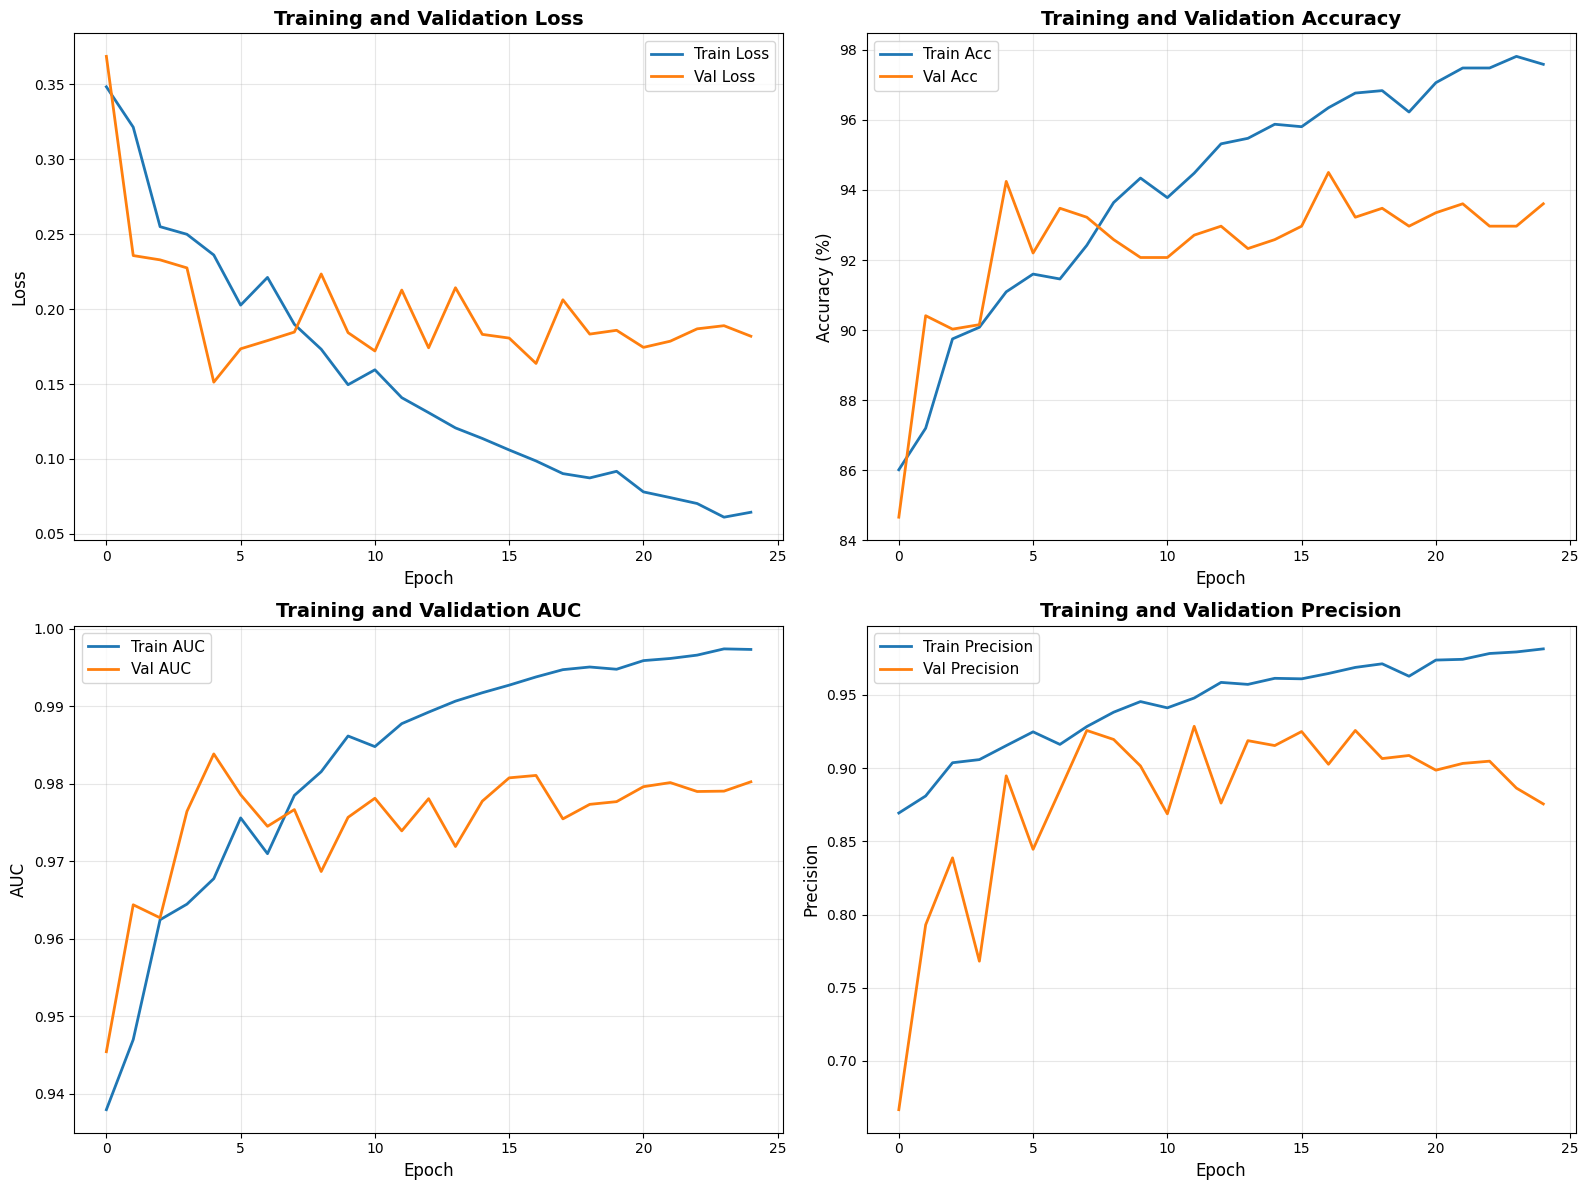

In [15]:
# %% Plot Training History
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', linewidth=2)
ax2.plot(history['val_acc'], label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# AUC plot
ax3.plot(history['train_auc'], label='Train AUC', linewidth=2)
ax3.plot(history['val_auc'], label='Val AUC', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=12)
ax3.set_ylabel('AUC', fontsize=12)
ax3.set_title('Training and Validation AUC', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Precision plot
ax4.plot(history['train_precision'], label='Train Precision', linewidth=2)
ax4.plot(history['val_precision'], label='Val Precision', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('Precision', fontsize=12)
ax4.set_title('Training and Validation Precision', fontsize=14, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

In [24]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
    # Validate - updated to unpack all 9 return values
    
test_loss, test_acc, test_preds, test_labels, test_probs, test_precision, test_recall, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# ROC AUC Score
auc = roc_auc_score(test_labels, test_probs)
print(f"\nROC AUC Score: {auc:.4f}")


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.47it/s]


Test Results:
Test Loss: 0.1355
Test Accuracy: 95.16%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.97      0.96      0.97       568
      Nodule       0.90      0.93      0.91       217

    accuracy                           0.95       785
   macro avg       0.94      0.95      0.94       785
weighted avg       0.95      0.95      0.95       785


ROC AUC Score: 0.9872


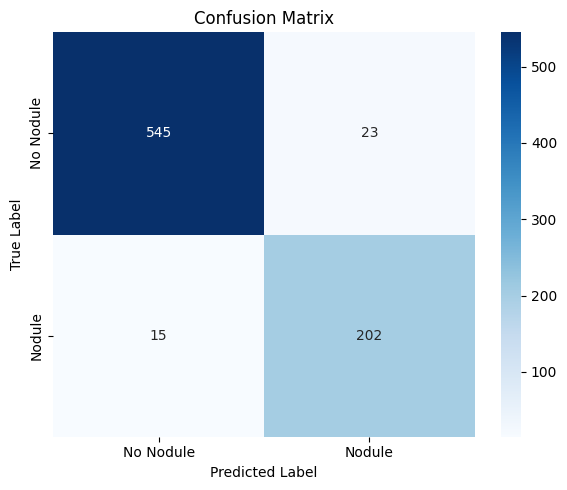

✓ Saved: confusion_matrix.png


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
cm_labels = ['No Nodule', 'Nodule']

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
print("✓ Saved: confusion_matrix.png")


In [23]:
# %% Load Best Model and Evaluate on Test Set
print("\nLoading best model for testing...")
best_model_path = 'best_resvit_multiscale.pth'
model = ResNetWithMultiScaleAttention(num_classes=2, pretrained=False, num_heads=2, dropout=0.1)
model = model.to(device)
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc, test_preds, test_labels, test_probs, test_prec, test_rec, test_f1, test_auc = validate(model, test_loader, criterion, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test ROC AUC: {test_auc:.4f}")

print(f"\n" + "="*70)
print("TEST SET RESULTS")
print("="*70)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['No Nodule', 'Nodule']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)


Loading best model for testing...


Validation: 100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Test Loss: 0.1355
Test Accuracy: 95.16%
Test Precision: 0.8978
Test Recall: 0.9309
Test F1-score: 0.9140
Test ROC AUC: 0.9872

TEST SET RESULTS
Test Loss: 0.1355
Test Accuracy: 95.16%

Classification Report:
              precision    recall  f1-score   support

   No Nodule       0.97      0.96      0.97       568
      Nodule       0.90      0.93      0.91       217

    accuracy                           0.95       785
   macro avg       0.94      0.95      0.94       785
weighted avg       0.95      0.95      0.95       785


Confusion Matrix:
[[545  23]
 [ 15 202]]


In [37]:
from JSRTDataset import JSRTDataset
# Define transforms - MUST match your training transforms exactly
jsrt_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Reload JSRT dataset with proper preprocessing
print("\n" + "="*60)
print("LOADING JSRT DATASET WITH PROPER PREPROCESSING")
print("="*60)

jsrt_csv_path = './dataset_nodule/jsrt_metadata.csv'
jsrt_images_dir = './dataset_nodule/images/images/'

jsrt_dataset = JSRTDataset(jsrt_csv_path, jsrt_images_dir, transform=jsrt_transform)
jsrt_loader = DataLoader(jsrt_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                         num_workers=NUM_WORKERS, pin_memory=True)

print(f"\n✓ JSRT DataLoader created with:")
print(f"  - CLAHE intensity normalization (simulates CXR standardization)")
print(f"  - Resize to {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  - ImageNet normalization")
print(f"  - Batch size: {BATCH_SIZE}")


LOADING JSRT DATASET WITH PROPER PREPROCESSING
JSRT Dataset loaded:
  Total samples: 247
  Nodules: 154
  Non-nodules: 93

✓ JSRT DataLoader created with:
  - CLAHE intensity normalization (simulates CXR standardization)
  - Resize to 224x224
  - ImageNet normalization
  - Batch size: 16



RE-EVALUATING WITH PROPER PREPROCESSING

Loading best model from ./best_resvit_multiscale.pth...
✓ Model loaded successfully

Evaluating on JSRT dataset (247 samples)...
Testing on 247 samples...


Testing: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


JSRT DATASET TEST RESULTS (WITH PROPER PREPROCESSING)

Dataset Statistics:
  Total samples tested: 247
  Actual nodules: 154
  Actual non-nodules: 93

Overall Metrics:
  Test Accuracy: 62.35%
  Precision: 0.6235
  Recall: 1.0000
  F1 Score: 0.7681
  ROC AUC Score: 0.5054

------------------------------------------------------------
Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

   No Nodule       0.00      0.00      0.00        93
      Nodule       0.62      1.00      0.77       154

    accuracy                           0.62       247
   macro avg       0.31      0.50      0.38       247
weighted avg       0.39      0.62      0.48       247


------------------------------------------------------------
Prediction Distribution:
------------------------------------------------------------
  Class 1 (Nodule): 247 samples (100.00%)



c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Edrill-LT\Documents\Projects\Python\Thoracic-Disease-Classifier-ResNet50\.torch\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

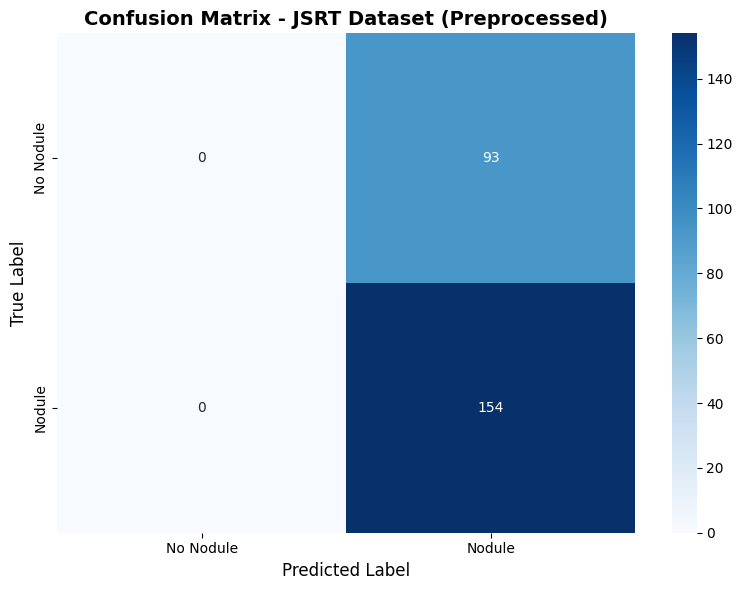


✓ Saved: confusion_matrix_jsrt_preprocessed.png


In [38]:
# %% Re-evaluate with Proper Preprocessing
print("\n" + "="*60)
print("RE-EVALUATING WITH PROPER PREPROCESSING")
print("="*60)

# Load the trained model
print("\nLoading best model from ./best_resvit_multiscale.pth...")
checkpoint = torch.load('./best_resvit_multiscale.pth')

model = ResNetWithMultiScaleAttention(num_classes=2, pretrained=False, num_heads=4, dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
print("✓ Model loaded successfully")

# Evaluate on JSRT dataset with proper preprocessing
print(f"\nEvaluating on JSRT dataset ({len(jsrt_dataset)} samples)...")
jsrt_acc, jsrt_preds, jsrt_labels, jsrt_probs, jsrt_precision, jsrt_recall, jsrt_f1, jsrt_auc = test_model(
    model, jsrt_loader, device
)

# Print results
print("\n" + "="*60)
print("JSRT DATASET TEST RESULTS (WITH PROPER PREPROCESSING)")
print("="*60)

print(f"\nDataset Statistics:")
print(f"  Total samples tested: {len(jsrt_labels)}")
print(f"  Actual nodules: {sum(jsrt_labels)}")
print(f"  Actual non-nodules: {len(jsrt_labels) - sum(jsrt_labels)}")

print(f"\nOverall Metrics:")
print(f"  Test Accuracy: {jsrt_acc:.2f}%")
print(f"  Precision: {jsrt_precision:.4f}")
print(f"  Recall: {jsrt_recall:.4f}")
print(f"  F1 Score: {jsrt_f1:.4f}")
print(f"  ROC AUC Score: {jsrt_auc:.4f}")

# Classification Report
print("\n" + "-"*60)
print("Detailed Classification Report:")
print("-"*60)
print(classification_report(jsrt_labels, jsrt_preds, target_names=['No Nodule', 'Nodule']))

# Check prediction distribution
unique, counts = np.unique(jsrt_preds, return_counts=True)
pred_distribution = dict(zip(unique, counts))

print("\n" + "-"*60)
print("Prediction Distribution:")
print("-"*60)
for class_idx, count in pred_distribution.items():
    class_name = "Nodule" if class_idx == 1 else "No Nodule"
    percentage = (count / len(jsrt_preds)) * 100
    print(f"  Class {class_idx} ({class_name}): {count} samples ({percentage:.2f}%)")

# Confusion matrix
cm = confusion_matrix(jsrt_labels, jsrt_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Nodule', 'Nodule'], 
            yticklabels=['No Nodule', 'Nodule'])
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - JSRT Dataset (Preprocessed)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_jsrt_preprocessed.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: confusion_matrix_jsrt_preprocessed.png")